1. Import dataset file into pyspark dataframe 

In [2]:
import pandas as pd
import os

To read the csv file, we will mount the drive(google drive) onto google colab which served as our workspace for this assignment. The dataset used in this assignment was uploaded to google drive.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We then install pyspark to allow us access to the necessary libraries that will be need for this assignment.

In [4]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=9f4b2e1a7cee73e579afa4e25c6c504a4e4c60175c0a9932a30ed97eda5c3978
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [5]:
from pyspark.sql import SparkSession

# Next step is to create a SparkSession and we give it the appName 'Assignment' 
spark = SparkSession.builder \
    .appName("Assignment") \
    .getOrCreate()

# After mounting the drive, we then define the path of csv file in the google drive and 
# assign it to the variable dataset_path.

dataset_path = "/content/drive/MyDrive/medical_info.csv"

# Read the dataset from our csv file on the drive into a DataFrame and we assign it to the variable 'first_dataframe'
first_dataframe = spark.read.csv(dataset_path, header=True, inferSchema=True)

# Display the DataFrame schema
first_dataframe.printSchema()

# we want to display 10 rows from the DataFrame
first_dataframe.show(10)


root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Outcome: integer (nullable = true)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          

2. Replace the null/missing values in the ‘SkinThickness’ feature and ‘Insulin’ feature

To replace the missing values in the skinThickness and Insulin columns, we will firstly extract the columns out in order to see some of the missing values we want to replace. 

In [6]:
first_dataframe.select(['SkinThickness','Insulin']).show()

+-------------+-------+
|SkinThickness|Insulin|
+-------------+-------+
|           35|      0|
|           29|      0|
|            0|      0|
|           23|     94|
|           35|    168|
|            0|      0|
|           32|     88|
|            0|      0|
|           45|    543|
|            0|      0|
|            0|      0|
|            0|      0|
|            0|      0|
|           23|    846|
|           19|    175|
|            0|      0|
|           47|    230|
|            0|      0|
|           38|     83|
|           30|     96|
+-------------+-------+
only showing top 20 rows



After this, we will import the col, when and median functions. The col function allows us to access the specific column we want to manipulate and then we will assign the column to a new alias e.g SkinThickness_median

After this we will calculate the median values and then assign it to a new  variable e.g 'skin_thickness_median'.

Lastly, using the when statement we replace the 0 values with the median values and then we assign the new dataframe to a variable "second_df"   

In [7]:
from pyspark.sql.functions import col, when, median
median_values = first_dataframe.select(
    median(col('SkinThickness')).alias('SkinThickness_median'),
    median(col('Insulin')).alias('Insulin_median')
).first()

# Extracting the median values
skin_thickness_median = median_values['SkinThickness_median']
insulin_median = median_values['Insulin_median']

#Then we will replace 0 values with median values in the 'SkinThickness' and 'Insulin' columns respectively.
second_df = first_dataframe.withColumn(
    'SkinThickness',
    when(col('SkinThickness') == 0, skin_thickness_median).otherwise(col('SkinThickness'))
).withColumn(
    'Insulin',
    when(col('Insulin') == 0, insulin_median).otherwise(col('Insulin'))
)

# Show the second DataFrame
second_df.show()

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|         35.0|   30.5|33.6|                   0.627| 50|      1|
|          1|     85|           66|         29.0|   30.5|26.6|                   0.351| 31|      0|
|          8|    183|           64|         23.0|   30.5|23.3|                   0.672| 32|      1|
|          1|     89|           66|         23.0|   94.0|28.1|                   0.167| 21|      0|
|          0|    137|           40|         35.0|  168.0|43.1|                   2.288| 33|      1|
|          5|    116|           74|         23.0|   30.5|25.6|                   0.201| 30|      0|
|          3|     78|           50|         32.0|   88.0|31.0|                   0.248| 26|      1|


3. Create a new PySpark DataFrame by removing rows from the 2nd DataFrame if a row’s ‘Glucose’ feature, ‘BloodPressure’ feature , or ‘BMI’ feature has null/missing values

To do this, we use the filter function. This filters the colums 'Glucose', 'BloodPressure', 'BMI' whose values is not equal to zero and then appends it to a new variable "third_df". 

To calculate the total number of removed rows, we subtract second_df from third_df and assign the answer to a new variable "removed_rows"

In [8]:
from pyspark.sql.functions import col

# Remove rows with null/missing values (0 values) in 'Glucose', 'BloodPressure', or 'BMI' columns
third_df = second_df.filter((col('Glucose') != 0) & (col('BloodPressure') != 0) & (col('BMI') != 0))

# Calculating the total number of rows removed
removed_rows = second_df.count() - third_df.count()

third_df.show()

# This displays the total Output of the total number of rows removed
print("Total number of removed rows:", removed_rows)


+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|         35.0|   30.5|33.6|                   0.627| 50|      1|
|          1|     85|           66|         29.0|   30.5|26.6|                   0.351| 31|      0|
|          8|    183|           64|         23.0|   30.5|23.3|                   0.672| 32|      1|
|          1|     89|           66|         23.0|   94.0|28.1|                   0.167| 21|      0|
|          0|    137|           40|         35.0|  168.0|43.1|                   2.288| 33|      1|
|          5|    116|           74|         23.0|   30.5|25.6|                   0.201| 30|      0|
|          3|     78|           50|         32.0|   88.0|31.0|                   0.248| 26|      1|


4. Compute the min value, max value, mean value, median value, variance and standard deviation. Generate a histogram for the ‘BloodPressure feature and describe the distribution of the feature.

To get the min value, max value, mean value, median value, and standard deviation we will use the summary_statistics function to compute the summary statistics of the BoodPressure feature. After this, we will extract the summary statistics values and apply it to new variable e.g 'min_value, max_value' etc... 

To generate the histogram for the BloodPressure feature, we will import pyplot from matplotlib. The BloodPressure is ploted along the x-axis and the frequenct along the y-axis.

From the histogram chart, we can deduce that blood pressure values between 60 - 80 appeared the most (i.e having the highest frequecies) while blood pressure values between 20 - 40 appeared the least (i.e having the least frequecies)

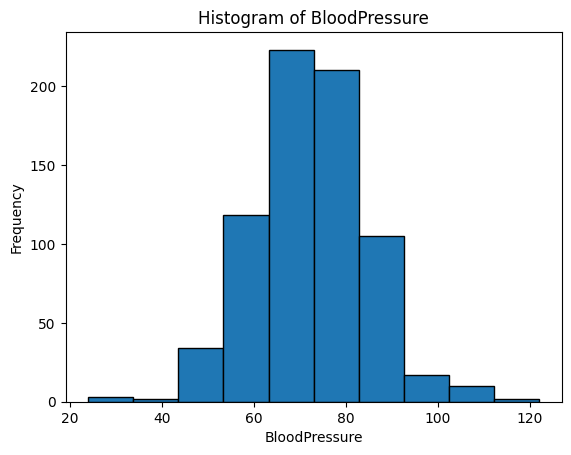

Distribution of the 'BloodPressure' feature:
Min: 24.0
Max: 122.0
Mean: 72.40055248618785
Median: 72.0
Standard Deviation: 12.379870321719064


In [17]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import variance

# Compute summary statistics of the 'BloodPressure' feature
summary_statistics = third_df.select(
    col('BloodPressure').alias('BloodPressure')
).summary('min', 'max', 'mean', '50%', 'stddev')

# Extract the summary statistics values
min_value = float(summary_statistics.where(col('summary') == 'min').select('BloodPressure').first()['BloodPressure'])
max_value = float(summary_statistics.where(col('summary') == 'max').select('BloodPressure').first()['BloodPressure'])
mean_value = float(summary_statistics.where(col('summary') == 'mean').select('BloodPressure').first()['BloodPressure'])
median_value = float(summary_statistics.where(col('summary') == '50%').select('BloodPressure').first()['BloodPressure'])
standard_deviation_value = float(summary_statistics.where(col('summary') == 'stddev').select('BloodPressure').first()['BloodPressure'])

# Generate a histogram for the 'BloodPressure' feature
blood_pressure_values = third_df.select('BloodPressure').rdd.flatMap(lambda x: x).collect()
plt.hist(blood_pressure_values, bins=10, edgecolor='black')
plt.xlabel('BloodPressure')
plt.ylabel('Frequency')
plt.title('Histogram of BloodPressure')
plt.show()

# Describe the distribution of the 'BloodPressure' feature
print("Distribution of the 'BloodPressure' feature:")
print(f"Min: {min_value}")
print(f"Max: {max_value}")
print(f"Mean: {mean_value}")
print(f"Median: {median_value}")
print(f"Standard Deviation: {standard_deviation_value}")


5. Display the quartile info of the ‘BMI’ feature in the 3rd DataFrame.

Quartile Information:
First Quartile (Q1): 27.4
Median (Q2): 32.0
Third Quartile (Q3): 36.4


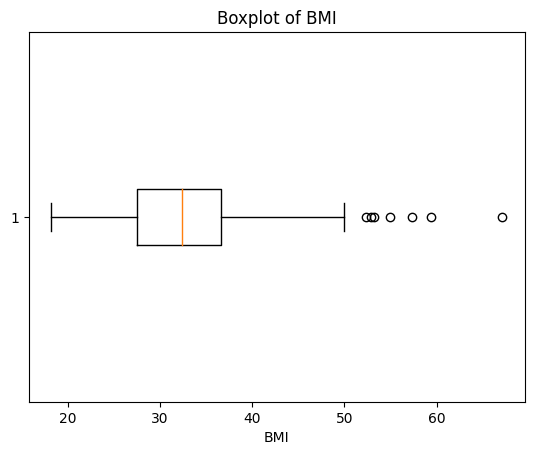

In [18]:
# Display quartile information of 'BMI' feature
quartiles = third_df.approxQuantile('BMI', [0.25, 0.5, 0.75], 0.01)
first_quartile, median, third_quartile = quartiles

print("Quartile Information:")
print("First Quartile (Q1):", first_quartile)
print("Median (Q2):", median)
print("Third Quartile (Q3):", third_quartile)

# Generate a boxplot for 'BMI' feature
bmi_values = third_df.select("BMI").rdd.flatMap(lambda x: x).collect()
plt.boxplot(bmi_values, vert=False)
plt.xlabel('BMI')
plt.title('Boxplot of BMI')
plt.show()


6. Use a graph to explore and describe the relationship between BMI feature and SkinThickness

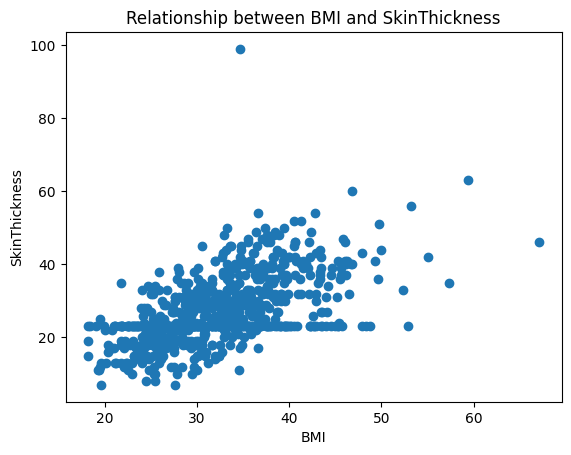

Pearson Correlation Coefficient: 0.5600712181851463


In [19]:
from scipy.stats import pearsonr

# Extract 'BMI' and 'SkinThickness' values
bmi_values = third_df.select("BMI").rdd.flatMap(lambda x: x).collect()
skin_thickness_values = third_df.select("SkinThickness").rdd.flatMap(lambda x: x).collect()

# Plot the relationship between 'BMI' and 'SkinThickness'
plt.scatter(bmi_values, skin_thickness_values)
plt.xlabel('BMI')
plt.ylabel('SkinThickness')
plt.title('Relationship between BMI and SkinThickness')
plt.show()

# Compute the Pearson correlation between 'BMI' and 'SkinThickness'
correlation_coefficient, p_value = pearsonr(bmi_values, skin_thickness_values)

# Print the Pearson correlation coefficient
print("Pearson Correlation Coefficient:", correlation_coefficient)

7. Use Spark SQL query to display the ‘Age’ feature and BloodPressure feature in the 3rd DataFrame where Age is less than 50 and BloodPressure is great than 100.

In [20]:
# Register the DataFrame as a temporary view
third_df.createOrReplaceTempView("third_df")

# Execute the Spark SQL query
query = """
    SELECT Age, BloodPressure
    FROM third_df
    WHERE Age < 50 AND BloodPressure > 100
"""

result = spark.sql(query)

# Display the result
result.show()

+---+-------------+
|Age|BloodPressure|
+---+-------------+
| 37|          108|
| 27|          122|
| 26|          110|
| 45|          102|
| 41|          104|
| 37|          110|
| 43|          106|
| 47|          106|
| 44|          114|
+---+-------------+



8. build a Decision Tree classifier using all other features as predictors. 

In [21]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


# Create a VectorAssembler to combine the predictor columns into a single vector column
assembler = VectorAssembler(
    inputCols=["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"],
    outputCol="features"
)

# Transform the DataFrame to include the features vector
df_features = assembler.transform(third_df)

# Split the data into training and testing sets
train_data, test_data = df_features.randomSplit([0.8, 0.2], seed=42)

# Create a DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier(labelCol="Outcome", featuresCol="features")

# Fit the DecisionTreeClassifier to the training data
model = dt_classifier.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Evaluate the model using the accuracy metric
evaluator = MulticlassClassificationEvaluator(labelCol="Outcome", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

# Print the accuracy of the model
print("Accuracy:", accuracy)


Accuracy: 0.717948717948718


**Conclusion:**
Using the decision tree classifier, we got an accuracy of 0.717948717948718. The accuracy represents the proportion of correctly classified instances in the test data. In this example, the accuracy is 0.717 (or 71.8%), which indicates that the Decision Tree classifier achieved 71.8% accuracy in predicting the 'Outcome' label based on the provided features.






9. build a Logistic Regression classifier using all other features as predictors.

In [22]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Create a VectorAssembler to combine the predictor columns into a single vector column
assembler = VectorAssembler(
    inputCols=["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"],
    outputCol="features"
)

# Transform the DataFrame to include the features vector
df_features = assembler.transform(third_df)

# Split the data into training and testing sets
train_data, test_data = df_features.randomSplit([0.8, 0.2], seed=42)

# Create a LogisticRegressionClassifier
lr_classifier = LogisticRegression(labelCol="Outcome", featuresCol="features")

# Fit the LogisticRegressionClassifier to the training data
model = lr_classifier.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Evaluate the model using the accuracy metric
evaluator = MulticlassClassificationEvaluator(labelCol="Outcome", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

# Print the accuracy of the model
print("Accuracy:", accuracy)

Accuracy: 0.7948717948717948


**Conclusion:**
Using the logistic regression classifier, we got an accuracy of 0.7948717948717948. The accuracy represents the proportion of correctly classified instances in the test data. In this example, the accuracy is 0.79 (or 79%), which indicates that the Logistic regression classifier achieved 79% accuracy in predicting the 'Outcome' label based on the provided features.

NOTE: Based on the camparison of the accuracy between the decision  tree classifier and the logistic regression classifier, the logistic regression classifier performed better than the decision tree classifier for the classification. 

10. Build a linear regression model to predict SkinThickness feature in the using BMI feature as the predictor.

In [23]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler

# Create a VectorAssembler to combine the predictor 'BMI' into a single feature column
assembler = VectorAssembler(inputCols=['BMI'], outputCol='features')

# Transform the DataFrame by assembling the features
df_feature = assembler.transform(third_df)

# Split the data into training and testing sets
train_data, test_data = df_feature.randomSplit([0.8, 0.2], seed=42)

# Create a LinearRegression model
lr = LinearRegression(featuresCol='features', labelCol='SkinThickness')

# Fit the model on the training data
lr_model = lr.fit(train_data)

# Make predictions on the testing data
predictions = lr_model.transform(test_data)

# Evaluate the model's performance
evaluator = RegressionEvaluator(labelCol='SkinThickness', predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(predictions)

# Print the root mean squared error (RMSE) of the model
print('Root Mean Squared Error (RMSE):', rmse)


Root Mean Squared Error (RMSE): 7.682616858855491


**Conclusion:**
The model's performance was evaluated by calling the evaluate() method on the evaluator object, and computing the root mean squared error (RMSE) of the model.

The RMSE represents the average deviation of the predicted 'SkinThickness' values from the actual values. In this case, the model achieves an RMSE of approximately 7.683, indicating that the average prediction error in 'SkinThickness' using the 'BMI' feature as the predictor is 7.683 units.